load data and starting to do hypothesis tests

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro

In [2]:
path = '../Datasets/dataframe.csv'
df = pd.read_csv(path);df.head(3)

,Date,Omerli,Darlik,Elmali,Terkos,Alibey,Buyukcekmece,Sazlidere,Kazandere,Pabucdere,Istrancalar
0,01-01-2017,81.07,72.94,0.52,44.45,56.18,33.13,34.07,28.84,13.07,40.24
1,01-02-2017,82.16,74.11,0.51,44.93,58.38,33.63,34.64,28.57,12.99,34.68
2,01-03-2017,82.63,74.59,0.51,45.09,59.26,33.63,34.87,28.17,12.93,29.18


### Normality test  
$ H_0: $ Zero difference between data distribution and normal distribution

In [7]:
for i in df.columns[1:].tolist():
    stat, p = shapiro(df[i])
    alpha = 0.05
    if p > alpha:
        print(f'{i} Normally distributed')
    else:
        print(f'{i} is not Normally distributed')

Omerli is not Normally distributed
Darlik is not Normally distributed
Elmali is not Normally distributed
Terkos is not Normally distributed
Alibey is not Normally distributed
Buyukcekmece is not Normally distributed
Sazlidere is not Normally distributed
Kazandere is not Normally distributed
Pabucdere is not Normally distributed
Istrancalar is not Normally distributed


We can't use regression because of normality test results. Dataset must be normally distributed.

### Time Series Analysis

In [39]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date',inplace=True);df.head(3)

,Omerli,Darlik,Elmali,Terkos,Alibey,Buyukcekmece,Sazlidere,Kazandere,Pabucdere,Istrancalar
Date,,,,,,,,,,
2017-01-01,81.07,72.94,0.52,44.45,56.18,33.13,34.07,28.84,13.07,40.24
2017-01-02,82.16,74.11,0.51,44.93,58.38,33.63,34.64,28.57,12.99,34.68
2017-01-03,82.63,74.59,0.51,45.09,59.26,33.63,34.87,28.17,12.93,29.18


check stationary to time-series

In [41]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('ADF Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [45]:
train = df[df.index < '2020-01-01']
test = df[df.index >='2020-01-01']

In [49]:
adf_test(df['Omerli'])

ADF Test Results:
Test Statistic                   -2.787614
p-value                           0.060065
#Lags Used                       23.000000
Number of Observations Used    1437.000000
Critical Value (1%)              -3.434909
Critical Value (5%)              -2.863553
Critical Value (10%)             -2.567842
dtype: float64


Omerli data is not stationary

In [55]:
omerli = df['Omerli'].diff().dropna();adf_test(omerli)

ADF Test Results:
Test Statistic                   -4.070736
p-value                           0.001082
#Lags Used                       22.000000
Number of Observations Used    1437.000000
Critical Value (1%)              -3.434909
Critical Value (5%)              -2.863553
Critical Value (10%)             -2.567842
dtype: float64


set the ARIMA models

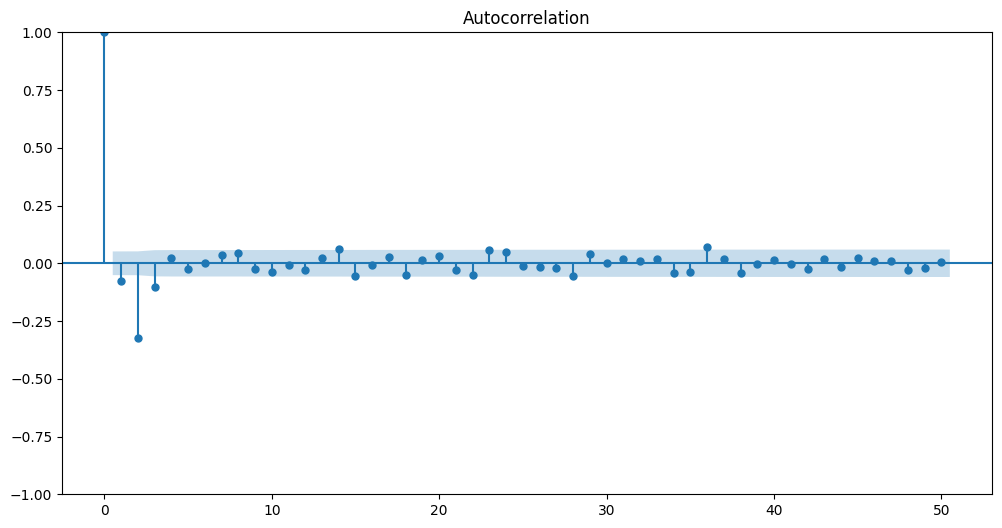

c:\Users\ramaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


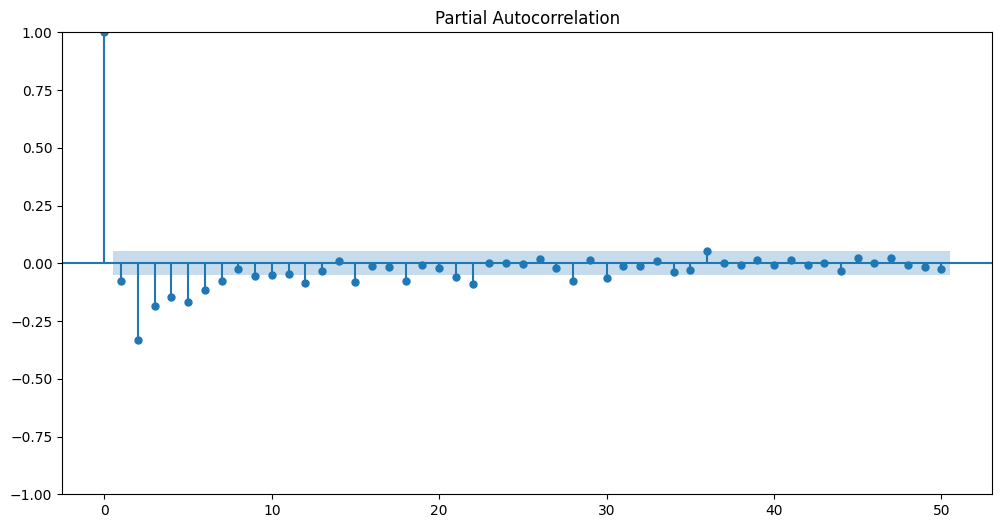

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(omerli.diff().dropna(), lags=50, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(omerli.diff().dropna(), lags=50, ax=ax)
plt.show()

Data is stationary and there is no seasonality. Also ACF graph is faster than PACF so the model is MA(q). q=3, p=0 and d=2 ARIMA(3,2,0)

In [58]:
import statsmodels.api as sm

In [66]:
import statsmodels.api as sm
model = sm.tsa.ARIMA(train['Omerli'], order=(3,2,0))

c:\Users\ramaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ramaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ramaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [67]:
results = model.fit()
forecast = results.forecast(steps=365)

In [82]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['Omerli'].iloc[:-1].values, forecast.values)
rmse = np.sqrt(mse)
print('RMSE:', round(rmse, 2))

RMSE: 401.14


RMSE value is too high for me and I've no time for developing the model and researching. That why I'll try outo arima and FbProphet.

Auto ARIMA Model

In [83]:
from pmdarima.arima import auto_arima

model = auto_arima(train['Omerli'], start_p=0, start_q=0,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1572.601, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1930.794, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1231.258, Time=0.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1181.167, Time=1.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1604.105, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=11.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1328.281, Time=0.60 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=19.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.61 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=4.56 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1182.712, Time=2.58 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Tota

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1095
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -587.583
Date:                            Fri, 07 Apr 2023   AIC                           1181.167
Time:                                    23:08:54   BIC                           1196.126
Sample:                                01-01-2017   HQIC                          1186.831
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5313      0.015     36.243      0.000       0.503       0.560
ma.S.L12      -0.7987      0.014    -59.039      0.000      -0.825      -0.772
sigma2         0.1715      0.003     66.951      0.000       0.166       0.176
===================================================================================
Ljung-Box (L1) (Q):                  37.28   Jarque-Bera (JB):             14477.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             2.36
Prob(H) (two-sided):                  0.03   Kurtosis:                        20.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

When I look at the ARIMA results, I can tell use the ARIMA model is not seems a good idea. ARIMA models are not good at the long term datasets.

I would like to keep ressearching and develop the models or using FbProphet but I've just less time. So I'll share my opinion on `../Reporting_ideas.md` and I'll close the project.